# Effectuez une prédiction de revenus

### Mission 3

- Nous supposons ici que l'on associe à chaque individu i une unique classe c(i,parent)  quel que soit le nombre de parents de i.
- Nous allons donc simuler cette information grâce à un coefficient **pj** (propre à chaque pays **j**) mesurant une corrélation entre le revenu de l'individu i et le revenu de ses parents. Ce coefficient sera ici appelé **coefficient d'élasticité**. Il mesure la **mobilité intergénérationnelle du revenu**.

 - IGEincome is the measure of relative mobility in income which is generated in three steps: (1) estimate an income equation from an older sample that is representative of the current population of parents (when they were younger, i.e. pseudo-parents), (2) use the estimated model coefficients (i.e. returns to education and experience) to predict parental earnings at the reference age using the retrospective data on parental age and education as explanatory variables, and (3) regress child earnings at the reference age on predicted parental earnings at the reference age. The resulting regression coefficients from step 3 are reported as IGEincome.

### Sommaire
- [importation des librairies](#librairies)
- [importation et lecture des données](#donnee_revenus)
- [générez un grand nombre de réalisations d'une variable que nous appellerons selon une loi normale. Le choix de la moyenne et de l'écart-type n'auront pas d'incidence sur le résultat final. ln(yparent) doit être supérieur à 1000 fois le nombre de quantiles](#gd_nb)

### Importation des librairies <a class="anchor" id="librairies"></a>

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats as st

In [2]:
ENCODAGE = 'UTF-8'

In [3]:
sns.set(style="darkgrid")

### Importation et lecture des données  <a class="anchor" id="donnee_revenus"></a>
http://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim

In [4]:
# fichier de mission 2 (country_code, year, quantile, nb_quantiles, income, gdpppp, country, gini_mean)
df_distrib_revenus_mean_gini = pd.read_csv('revenu_pays_mean_gini.csv', encoding= ENCODAGE).copy()

In [5]:
df_distrib_revenus_mean_gini.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country,gini_mean
0,ALB,2008,1,100,728.89795,7297.0,Albania,30.0
1,ALB,2008,2,100,916.66235,7297.0,Albania,30.0


In [6]:
# # Lecture de fichier
# with open('revenu_pays_mean_gini', 'rb') as f1:
#     df_distrib_revenus_mean_gini1 = pickle.load(f1)

In [7]:
# fichier GDIM dataset de la Baque Mondiale =>  IGEincome == coefficient d'élasticité
df_GDMI_brut = pd.read_csv("GDIMMay2018.csv", encoding= ENCODAGE)
df_GDMI_brut.head(2)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1


In [105]:
df_GDMI_brut.shape

(6504, 66)

In [8]:
df_GDMI_province = pd.read_csv("GDIMprovinceMay2018.csv", encoding= ENCODAGE)
df_GDMI_province.head(2)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,provincename,province,cohort,year,...,survey,status,parent,child,obs,IGE,BHQ4,Q4child,MLD_psu,BHQ4adj
0,Brazil,BRA,BRA,Latin America & Caribbean,Developing economies,Upper middle income,Acre,2,1980,1980,...,PNAD,Retrospective question,max,all,67,0.401910,0.046689,0.14657,0.098349,-0.099881
1,Brazil,BRA,BRA,Latin America & Caribbean,Developing economies,Upper middle income,Alagoas,14,1980,1980,...,PNAD,Retrospective question,max,all,57,0.322206,0.110421,0.21679,0.067774,-0.106369


In [9]:
df_GDMI_province.countryname.unique()

array(['Brazil', 'China', 'Egypt, Arab Rep.', 'Indonesia', 'Nigeria'],
      dtype=object)

In [10]:
df_GDMI_brut.dtypes

countryname     object
wbcode          object
iso3            object
region          object
incgroup2       object
                ...   
IGEincome      float64
S1             float64
S2             float64
S3             float64
MLD_psu        float64
Length: 66, dtype: object

In [11]:
df_GDMI_brut.shape

(6504, 66)

In [12]:
# valeurs null 
df_GDMI_brut.isnull().sum()

countryname       0
wbcode            0
iso3              0
region            0
incgroup2         0
               ... 
IGEincome      5651
S1             3659
S2             3659
S3             3659
MLD_psu        5279
Length: 66, dtype: int64

Remarque : 5651 valeurs manquantes IGEincome

In [13]:
# valeurs dupliquées
df_GDMI_brut.duplicated().sum()

0

In [14]:
df_GDMI_brut.IGEincome.describe()

count    853.000000
mean       0.516928
std        0.249615
min        0.112876
25%        0.312578
50%        0.464077
75%        0.689613
max        1.095440
Name: IGEincome, dtype: float64

### Implémentation des Nan de IGEincome par la moyenne de IGEincome de la région du pays

#### Création d'un dataframe region - IGEincome(moyenne)

In [15]:
# récupération des colonnes utiles
df_GDMI_region_IGEinc_mean = df_GDMI_brut[['region', 'IGEincome']]
df_GDMI_region_IGEinc_mean.head(2)

,region,IGEincome
0,South Asia,NaN
1,South Asia,NaN


In [16]:
# dataframe region/IGEincome (moyenne de IGEincome)
df_GDMI_brut_region = df_GDMI_region_IGEinc_mean.groupby('region').mean().reset_index()
df_GDMI_brut_region.head(8)

,region,IGEincome
0,East Asia & Pacific,0.504399
1,Europe & Central Asia,0.465537
2,High income,0.348050
3,Latin America & Caribbean,0.896534
4,Middle East & North Africa,0.816695
5,South Asia,0.495351
6,Sub-Saharan Africa,0.655524


In [17]:
# df_GDMI_brut_region.loc[df_GDMI_brut_region['region']== 'East Asia & Pacific','IGEincome']

In [18]:
df_GDMI_brut_region.describe()

,IGEincome
count,7.000000
mean,0.597441
std,0.199823
min,0.348050
25%,0.480444
50%,0.504399
75%,0.736110
max,0.896534


In [19]:
# régions dont les valeurs de 'IGEincome' sont manquantes
df_GDMI_brut.loc[df_GDMI_brut['IGEincome'].isnull(),'region'].value_counts()

High income                   1792
Sub-Saharan Africa            1214
Europe & Central Asia         1060
Latin America & Caribbean      516
East Asia & Pacific            461
Middle East & North Africa     312
South Asia                     296
Name: region, dtype: int64

In [20]:
# pd.set_option('display.max_columns', None)
df_GDMI_brut.head(2)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1


In [21]:
# colonnes de travail
df_igeIncome = df_GDMI_brut[['countryname', 'iso3', 'region', 'IGEincome']]
df_igeIncome.head(2)

,countryname,iso3,region,IGEincome
0,Afghanistan,AFG,South Asia,NaN
1,Afghanistan,AFG,South Asia,NaN


In [22]:
df_igeIncome.shape

(6504, 4)

In [23]:
# renommage des colonnes
df_igeIncome.columns = ['country', 'country_code', 'region', 'IGEincome']
df_igeIncome.head(2)

,country,country_code,region,IGEincome
0,Afghanistan,AFG,South Asia,NaN
1,Afghanistan,AFG,South Asia,NaN


In [24]:
df_igeIncome.isnull().sum()

country            0
country_code       0
region             0
IGEincome       5651
dtype: int64

#### Création d'un dataframe ne contenant que les IGEincome nulls

In [25]:
df_igeIncome_null = df_igeIncome[df_igeIncome['IGEincome'].isnull()]
df_igeIncome_null.shape

(5651, 4)

Les valeurs null de IGEincome sont supprimées du dataframe principal "df_igeIncome"

In [26]:
df_igeIncome.shape

(6504, 4)

In [27]:
df_igeIncome_ss_null = df_igeIncome.dropna(axis=0)
df_igeIncome_ss_null.shape

(853, 4)

Implémentation des valeurs NaN de df_igeIncome_null avec les valeurs de df_GDMI_brut_region

In [28]:
df_IGEincome_impl = pd.merge(df_igeIncome_null,df_GDMI_brut_region, on='region', how='right').drop('IGEincome_x', axis=1)
df_IGEincome_impl.columns = ['country', 'country_code','region', 'IGEincome']
df_IGEincome_impl.head(2)

,country,country_code,region,IGEincome
0,China,CHN,East Asia & Pacific,0.504399
1,China,CHN,East Asia & Pacific,0.504399


In [29]:
df_IGEincome_impl.shape

(5651, 4)

In [30]:
# valeurs null => 0
df_IGEincome_impl.isnull().sum()

country         0
country_code    0
region          0
IGEincome       0
dtype: int64

#### Intégration des valeurs implémentées dans le dataframe principal "df_igeIncomeN"

In [31]:
df_igeIncomeN = pd.concat([df_igeIncome_ss_null,df_IGEincome_impl]).sort_values('country')

In [32]:
df_igeIncomeN.shape

(6504, 4)

In [33]:
df_igeIncomeN.head(2)

,country,country_code,region,IGEincome
4151,Afghanistan,AFG,South Asia,0.495351
4149,Afghanistan,AFG,South Asia,0.495351


In [34]:
df_igeIncomeN[df_igeIncomeN['country_code']== 'AUS'].head(2)

,country,country_code,region,IGEincome
1544,Australia,AUS,High income,0.34805
1543,Australia,AUS,High income,0.34805


#### Création du dataframe "df_pj_country" qui comprend les coef d'élasticité des pays

In [35]:
df_pj_country = df_igeIncomeN.groupby(['country_code','country' ],as_index=False).agg(pj = ("IGEincome", "mean"))

In [36]:
df_pj_country.head(2)

,country_code,country,pj
0,AFG,Afghanistan,0.495351
1,AGO,Angola,0.655524


In [37]:
df_pj_country.shape

(150, 3)

In [38]:
# Valeurs null => 0
df_pj_country.isnull().sum()

country_code    0
country         0
pj              0
dtype: int64

In [39]:
# Valeurs dupliquées => 0
df_pj_country.duplicated().sum()

0

In [40]:
df_pj_country.describe()

,pj
count,150.000000
mean,0.561845
std,0.182717
min,0.260000
25%,0.402436
50%,0.504399
75%,0.655524
max,0.936315


### Intégration des coefficients d'élasticité au dataframe principal " df_distrib_revenus_mean_gini"

In [41]:
df_distrib_revenus_mean_gini.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country,gini_mean
0,ALB,2008,1,100,728.89795,7297.0,Albania,30.0
1,ALB,2008,2,100,916.66235,7297.0,Albania,30.0


In [42]:
df_pj_country.drop('country', axis=1, inplace=True)

In [43]:
df_pj_country.head(2)

,country_code,pj
0,AFG,0.495351
1,AGO,0.655524


In [44]:
df_pj_country.isnull().sum()

country_code    0
pj              0
dtype: int64

In [45]:
df_distrib_revenus_mean_gini.isnull().sum()

country_code    0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
country         0
gini_mean       0
dtype: int64

In [46]:
df_gini_pj = pd.merge(df_pj_country, df_distrib_revenus_mean_gini, on='country_code', how="right")

In [47]:
df_gini_pj.shape

(11600, 9)

In [48]:
#  Pour une meilleure visibilité, réarrangement des colonnes
df_gini_pj = df_gini_pj.reindex(columns=['country_code','year','quantile','nb_quantiles','income','gdpppp',
                                        'country', 'gini_mean', 'pj'])

In [49]:
df_gini_pj.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country,gini_mean,pj
0,ALB,2008,1,100,728.89795,7297.0,Albania,30.0,0.535604
1,ALB,2008,2,100,916.66235,7297.0,Albania,30.0,0.535604


In [50]:
df_gini_pj.pj.isnull().sum()

200

#### Identification et implémentation des pj manquants

Pays concernés

In [51]:
# il manque le pj de SYR etXKX
df_gini_pj.loc[df_gini_pj['pj'].isnull(), 'country_code'].value_counts()

XKX    100
SYR    100
Name: country_code, dtype: int64

Récupération des régions des pays sans coef d'élasticité

In [52]:
# imporation et lecture du fichier 'gini_province' => donne les régions des pays
province_pj_manquant = pd.read_csv('gini_province.csv')

In [53]:
province_pj_manquant.head(2)

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN


Recherche des régions et implémentation des coefs d'élasticité manquants dans "df_gini_pj"

In [54]:
# Récupération de la province des 2 pays au pj manquant 
pays_pj_manquant = ['XKX', 'SYR'] 
for pj_manquant in pays_pj_manquant :
    # recherche de la région 
    reg = province_pj_manquant[province_pj_manquant['Country Code'] == pj_manquant]['Region'].values
    # recherche de l'IGEincome correspondant à la région
    pj = df_GDMI_brut_region[df_GDMI_brut_region['region'] == reg[0]]['IGEincome'].values
    # implémentation de l'IGEincome dans le dataset
    df_gini_pj.loc[(df_gini_pj['pj'].isnull()) & (df_gini_pj['country_code'] == pj_manquant),'pj'] = pj[0]  
    

In [55]:
#  valeurs null => aucune 
df_gini_pj.isnull().sum()

country_code    0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
country         0
gini_mean       0
pj              0
dtype: int64

In [56]:
df_gini_pj.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country,gini_mean,pj
0,ALB,2008,1,100,728.89795,7297.0,Albania,30.0,0.535604
1,ALB,2008,2,100,916.66235,7297.0,Albania,30.0,0.535604


1. Générez un grand nombre de réalisations d'une variable que nous appellerons selon une loi normale. Le choix de la moyenne et de l'écart-type n'auront pas d'incidence sur le résultat final. ln(yparent) doit être supérieur à 1000 fois le nombre de quantiles 
2. Générez réalisations du terme d'erreur selon une loi normale de moyenne 0 et d'écart-type
<a class="anchor" id="gd_nb"></a>

In [57]:
def generate_incomes(n, pj):
    # 1. On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le calcul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)

    # 2.Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)

    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

3. Pour une valeur donnée de **pj** (par exemple 0.9), calculez **y_child**= exp(alpha+pj* ln(y_parent)+ epsilon. 
    - Le choix de alpha n'a aucune incidence sur le résultat final et peut être supprimé. 
    - A ce stade, **y_child** contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.

In [58]:
#  génère les revenus des enfants en fonction de celui des parents et du coefficient d'élasticité
nb_quantiles = 100
n = 1000 * nb_quantiles
pj = 0.9
y_child , y_parents = generate_incomes(n, pj)
print(f'y_child : {y_child}')
print(f'y_parent : {y_parents}')

y_child : [ 4.65621715  0.51891081  2.18499038 ... 18.01615342  5.45719426
  1.07491703]
y_parent : [1.97193716 0.12718645 0.8802475  ... 7.63122088 2.54540759 1.84918753]


4. Pour chacun des n individus générés, calculez la **classe de revenu c_i_child** ainsi que la **classe de revenu de ses parents c_i_parent** , à partir de **y_child** et **y_parent**

Calcul de la classe des revenus des enfants et des parents

In [59]:
# Retourne  un array  contenant les quantiles pour revenu_enfant (y_child) (indice commençant à 0)

def quantiles(l, nb_quantiles):
#  Si l = y_child (revenu_enfant) => longueur du df
    size = len(l) 
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    
# création des quantiles (pour chaque individu soit n quantiles (de 1 à 10 (np.unique(quantiles))))    
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    
# création d'un dict avec key = revenu_enfant (y_child) trié et valeur = quantiles ({0.016845952669623042: 1,... 
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    
# retourne  un array  contenant les quantiles pour revenu_enfant (y_child)
    return pd.Series([q_dict[e] for e in l])

In [60]:
# Retourne un df contenant les revenus enfants, parents et les classes de revenus enfants, parents

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
# classes avec les quantiles => pour chaque revenu il y a un quantile
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]

    return sample

In [61]:
# échantillon classe de revenu enfants - parents
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample.sort_values('c_i_child')

,y_child,y_parents,c_i_child,c_i_parent
13738,0.041265,0.178576,1,5
85798,0.033826,0.170195,1,4
85821,0.041709,0.494341,1,25
75870,0.022781,0.089828,1,1
85823,0.038196,0.118640,1,2
...,...,...,...,...
66691,28.316696,3.907780,100,92
10120,27.044446,2.291992,100,80
66589,69.181246,9.359894,100,99
10442,25.100077,4.674602,100,94


- 5. A partir de cette dernière information, estimez pour chaque c_i_child la distribution conditionnelle de c_i_parent. 
    - Par exemple, si vous observez **6 individus** ayant à la fois **c_i_child 	= 5** et **c_i_parent = 8**, et que **200 individus sur 20000** ont **c_i_child = 5**, alors la probabilité d'avoir c_i_parent = 8 sachant c_i_child = 5 et sachant pj=0.9 sera estimée à **6/200** (On note cette probabilité comme ceci : P(c_i_parent=8|c_i_child = 5, pj=0.9)=0.03). 
    - Si votre population est divisée en c classes de revenu, vous devriez alors avoir c² estimations de ces probabilités conditionnelles, pour chaque pays.


In [62]:
# Retourne une liste des fréquences des différentes combinaisons de classes enfants-parents 

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum() 
 
    if total == 0 :
        return [0] * nb_quantiles    

    for q_p in range(1, nb_quantiles+1):
# subset : df avec le count de c_i_parent == quantile(q_p) pour les différents quantiles de c_i_child 
# subset : c_i_child -  c_i_parent - counts
        subset = counts[counts.c_i_parent == q_p]
    
# si le subset existe, calcul de la fréquence de la combinaison c_i_child - c_i_parent (counts combi / total)
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
# sinon la fréquence est nulle 
        else:
            distrib += [0]
            
    return distrib   

In [63]:
# Comptage des différentes combinaisons de classes enfants-parents 

def conditional_distributions(sample, nb_quantiles):
# création d'un df qui indique le total de chaque combinaison de classes enfants-parents
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"] 
    
# création d'une matrice qui donne distribution du c_i_parent pour chaque quantile enfant    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]

    return np.array(mat) 
   

In [64]:
counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
counts = counts.reset_index()
counts.columns = ["c_i_child","c_i_parent","counts"] 
counts.sort_values('c_i_parent', ascending=False)

,c_i_child,c_i_parent,counts
9088,100,100,251
4636,51,100,3
6979,75,100,7
4042,45,100,1
5032,55,100,2
...,...,...,...
2683,32,1,5
2586,31,1,6
668,10,1,24
2489,30,1,2


In [65]:
distrib = []
total = counts["counts"].sum() 

for q_p in range(1, nb_quantiles+1):
# subset : df avec le count de c_i_parent == quantile(q_p) pour les différents quantiles de c_i_child 
# subset : c_i_child -  c_i_parent - counts
    subset = counts[counts.c_i_parent == q_p]
    
# si le subset existe, calcul de la fréquence de la combinaison c_i_child - c_i_parent (counts combi / total)
    if len(subset):
        nb = subset["counts"].values[0]
        distrib += [nb / total]
    else:
        distrib += [0]


In [66]:
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()  
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html    cumul = np.array([0] * nb_quantiles) 
    cumul = np.array([0] * nb_quantiles)
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)
    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")

    plt.show()

In [67]:
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

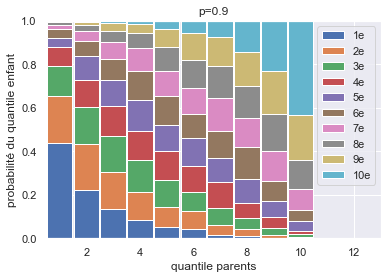

[[0.437 0.224 0.134 0.083 0.053 0.041 0.015 0.01  0.001 0.002]
 [0.217 0.209 0.171 0.132 0.092 0.084 0.044 0.032 0.014 0.005]
 [0.138 0.169 0.166 0.144 0.121 0.088 0.081 0.05  0.031 0.012]
 [0.087 0.127 0.137 0.133 0.134 0.119 0.121 0.072 0.054 0.016]
 [0.043 0.111 0.119 0.145 0.121 0.127 0.11  0.109 0.07  0.045]
 [0.041 0.068 0.096 0.133 0.135 0.111 0.124 0.146 0.094 0.052]
 [0.02  0.047 0.08  0.105 0.111 0.119 0.151 0.132 0.139 0.096]
 [0.012 0.026 0.052 0.067 0.114 0.132 0.145 0.149 0.17  0.133]
 [0.005 0.012 0.037 0.044 0.081 0.125 0.134 0.158 0.196 0.208]
 [0.    0.007 0.008 0.014 0.038 0.054 0.075 0.142 0.231 0.431]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.094


In [106]:
# coef élasticité fort => mobilité faible
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 10      # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon
y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)
c_i_child = 5 
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

In [69]:
print(f'{cd}')

[[0.455 0.232 0.135 0.083 0.047 0.026 0.012 0.01  0.   ]
 [0.246 0.207 0.174 0.145 0.096 0.065 0.041 0.021 0.005]
 [0.118 0.164 0.174 0.15  0.152 0.107 0.074 0.049 0.012]
 [0.083 0.153 0.139 0.154 0.132 0.135 0.102 0.072 0.03 ]
 [0.053 0.102 0.132 0.131 0.137 0.153 0.126 0.104 0.062]
 [0.032 0.065 0.107 0.141 0.144 0.153 0.147 0.134 0.077]
 [0.008 0.052 0.081 0.107 0.144 0.145 0.16  0.168 0.135]
 [0.004 0.014 0.048 0.06  0.092 0.134 0.196 0.231 0.221]
 [0.001 0.011 0.01  0.029 0.056 0.082 0.142 0.211 0.458]]


In [70]:
# cacul de la probabilité conditionnelle pour pj fort
c_i_child = 0
c_i_parent = 0
p = proba_cond(c_i_parent, c_i_child, cd)
p

0.455

In [71]:
c_i_child = 0
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
p

0.0

Remarque : fort coef d'élasticité équivaut à une mobilité faible (p faible)

In [72]:
sample.head()

,y_child,y_parents,c_i_child,c_i_parent
0,0.076126,0.600213,1,3
1,0.491257,0.635033,3,3
2,0.407994,0.496451,3,3
3,1.763595,1.961393,6,7
4,0.299989,1.120775,2,5


In [73]:
counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len).reset_index()
counts.columns = ["c_i_child","c_i_parent","counts"]
counts

,c_i_child,c_i_parent,counts
0,1,1,455
1,1,2,232
2,1,3,135
3,1,4,83
4,1,5,47
...,...,...,...
75,9,5,56
76,9,6,82
77,9,7,142
78,9,8,211


In [74]:
# matrice
mat = []
for child_quantile in np.arange(nb_quantiles)+1:
    subset = counts[counts['c_i_child'] == child_quantile]
    mat += [distribution(subset, nb_quantiles)]
mat

[[0.455, 0.232, 0.135, 0.083, 0.047, 0.026, 0.012, 0.01, 0],
 [0.246, 0.207, 0.174, 0.145, 0.096, 0.065, 0.041, 0.021, 0.005],
 [0.118, 0.164, 0.174, 0.15, 0.152, 0.107, 0.074, 0.049, 0.012],
 [0.083, 0.153, 0.139, 0.154, 0.132, 0.135, 0.102, 0.072, 0.03],
 [0.053, 0.102, 0.132, 0.131, 0.137, 0.153, 0.126, 0.104, 0.062],
 [0.032, 0.065, 0.107, 0.141, 0.144, 0.153, 0.147, 0.134, 0.077],
 [0.008, 0.052, 0.081, 0.107, 0.144, 0.145, 0.16, 0.168, 0.135],
 [0.004, 0.014, 0.048, 0.06, 0.092, 0.134, 0.196, 0.231, 0.221],
 [0.001, 0.011, 0.01, 0.029, 0.056, 0.082, 0.142, 0.211, 0.458]]

In [75]:
c_i_parent

8

In [76]:
c_i_child

0

In [77]:
cd

array([[0.455, 0.232, 0.135, 0.083, 0.047, 0.026, 0.012, 0.01 , 0.   ],
       [0.246, 0.207, 0.174, 0.145, 0.096, 0.065, 0.041, 0.021, 0.005],
       [0.118, 0.164, 0.174, 0.15 , 0.152, 0.107, 0.074, 0.049, 0.012],
       [0.083, 0.153, 0.139, 0.154, 0.132, 0.135, 0.102, 0.072, 0.03 ],
       [0.053, 0.102, 0.132, 0.131, 0.137, 0.153, 0.126, 0.104, 0.062],
       [0.032, 0.065, 0.107, 0.141, 0.144, 0.153, 0.147, 0.134, 0.077],
       [0.008, 0.052, 0.081, 0.107, 0.144, 0.145, 0.16 , 0.168, 0.135],
       [0.004, 0.014, 0.048, 0.06 , 0.092, 0.134, 0.196, 0.231, 0.221],
       [0.001, 0.011, 0.01 , 0.029, 0.056, 0.082, 0.142, 0.211, 0.458]])

In [78]:
p = proba_cond(c_i_parent, c_i_child, cd)
p

0.0

In [79]:
sample.c_i_child.values

array([1, 3, 3, ..., 9, 4, 2], dtype=int64)

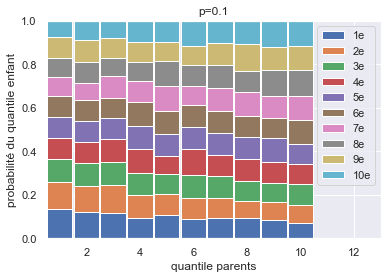

[[0.136 0.122 0.116 0.095 0.105 0.09  0.091 0.092 0.082 0.071]
 [0.122 0.119 0.127 0.102 0.1   0.095 0.092 0.078 0.083 0.082]
 [0.107 0.104 0.108 0.104 0.089 0.105 0.103 0.093 0.09  0.097]
 [0.097 0.096 0.106 0.111 0.085 0.12  0.099 0.101 0.094 0.091]
 [0.097 0.098 0.095 0.103 0.102 0.102 0.097 0.102 0.111 0.093]
 [0.096 0.095 0.093 0.111 0.103 0.1   0.105 0.094 0.094 0.109]
 [0.087 0.082 0.101 0.096 0.117 0.09  0.106 0.112 0.099 0.11 ]
 [0.087 0.095 0.083 0.089 0.112 0.096 0.102 0.098 0.119 0.119]
 [0.096 0.103 0.091 0.093 0.088 0.088 0.101 0.122 0.107 0.111]
 [0.075 0.086 0.08  0.096 0.099 0.114 0.104 0.108 0.121 0.117]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.1) = 0.094


In [107]:
# coef d'élasticité faible => forte mobilité
pj = 0.1                 # coefficient d'élasticité du pays j
nb_quantiles = 10     # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon
y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)
c_i_child = 5 
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

7. Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer (nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles

In [81]:
del y_child, y_parents

8. Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour **chaque individu de la Wold Income Distribution, créez-en 499 "clones"**. La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la Wold Income Distribution

In [82]:
df_gini_pj.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country,gini_mean,pj
0,ALB,2008,1,100,728.89795,7297.0,Albania,30.0,0.535604
1,ALB,2008,2,100,916.66235,7297.0,Albania,30.0,0.535604


In [83]:
df_gini_pj_ind = df_gini_pj.copy()

In [84]:
df_gini_pj_ind = df_gini_pj_ind[['country_code','quantile', 'income', 'pj', 'country', 'gini_mean']]
df_gini_pj_ind.head(5)

,country_code,quantile,income,pj,country,gini_mean
0,ALB,1,728.89795,0.535604,Albania,30.0
1,ALB,2,916.66235,0.535604,Albania,30.0
2,ALB,3,1010.91600,0.535604,Albania,30.0
3,ALB,4,1086.90780,0.535604,Albania,30.0
4,ALB,5,1132.69970,0.535604,Albania,30.0


In [85]:
df_gini_pj_ind.shape

(11600, 6)

In [86]:
# 1 quantile = 1 individu - il faut 499 clones individus au total 
# https://www.kaggle.com/arnopub/pandas-pr-sentation-des-dataframe
df_gini_pj_indS = df_gini_pj_ind.append([df_gini_pj_ind]* 499,ignore_index=True, sort=True)
df_gini_pj_indS.shape

(5800000, 6)

In [87]:
# vérification de la création de 500 individus pour chaque pays (100 * 500 = 50000)
df_gini_pj_indS.loc[df_gini_pj_indS['country_code']=='ALB'].count()

country         50000
country_code    50000
gini_mean       50000
income          50000
pj              50000
quantile        50000
dtype: int64

9. Pour chaque c_i_child et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes c_i_parent conformément aux distributions trouvées précédemment. Par exemple, si P(c_i_parent=8|c_i_child = 5, pj=0.9)=0.03, alors vous assignerez la classe c_i_parent=8 à 15 des 500 individus du pays j ayant c_i_child=5 , car 500*0.03 = 15

Même calcul que précédemment mais avec les pj correspondants

In [88]:
df_gini_pj_indS.head(2)

,country,country_code,gini_mean,income,pj,quantile
0,Albania,ALB,30.0,728.89795,0.535604,1
1,Albania,ALB,30.0,916.66235,0.535604,2


In [89]:
df_gini_pj_indS.sort_values(['country', 'quantile']).reset_index(drop=True, inplace=True)

In [90]:
df_gini_pj_indS.head(1)

,country,country_code,gini_mean,income,pj,quantile
0,Albania,ALB,30.0,728.89795,0.535604,1


In [91]:
# Renommage des colonnes
df_gini_pj_indS.rename(columns={'gini_mean': 'Gj'}, inplace=True)

In [92]:
df_gini_pj_indS.head(1)

,country,country_code,Gj,income,pj,quantile
0,Albania,ALB,30.0,728.89795,0.535604,1


#### Calcul du revenu moyen pour chaque pays

In [93]:
# Regroupement des pays par leur code iso3
df_mj = df_gini_pj_indS.groupby('country_code').agg(mj=("income","mean")).reset_index()

In [94]:
df_mj.head(2)

,country_code,mj
0,ALB,2994.829902
1,ARG,5847.884654


In [95]:
df_mj.isnull().sum()

country_code    0
mj              0
dtype: int64

In [96]:
# fusion pour incorporer le mj (revenu moyen du pays j) dans le dataframe principal
df_gini_pj_inc_mj = pd.merge(df_gini_pj_indS, df_mj, on='country_code', how='left')

In [97]:
df_gini_pj_inc_mj.head(2)

,country,country_code,Gj,income,pj,quantile,mj
0,Albania,ALB,30.0,728.89795,0.535604,1,2994.829902
1,Albania,ALB,30.0,916.66235,0.535604,2,2994.829902


In [98]:
df_gini_pj_inc_mj.isnull().sum()

country         0
country_code    0
Gj              0
income          0
pj              0
quantile        0
mj              0
dtype: int64

In [99]:
df_gini_pj_inc_mj.shape

(5800000, 7)

### Export des dataframes

#### Export du dataframe "df_mj" 

In [100]:
#  avec pickle Enregistrement
with open('df_mj', 'wb') as f3:
    pickle.dump(df_mj, f3)

In [101]:
# en csv
df_mj.to_csv('df_mj.csv', index = False, encoding=ENCODAGE)

#### Export du dataframe "df_gini_pj_inc_mj"

In [102]:
#  avec pickle Enregistrement
with open('df_gini_pj_inc_mj', 'wb') as f4:
    pickle.dump(df_gini_pj_inc_mj, f4)

In [103]:
# En csv
df_gini_pj_inc_mj.to_csv('df_gini_pj_inc_mj.csv', index = False, encoding=ENCODAGE)

#### Export du dataframe "df_gini_pj_indS" 

In [104]:
#  Enregistrement avec pickle
with open('df_gini_pj_indS', 'wb') as f2:
    pickle.dump(df_gini_pj_indS, f2)